In [1]:
import argparse
import os
import numpy as np
import math

from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt

import torchvision.utils as utils
from IPython.display import HTML
import time
from torchvision import models
import torch.nn.functional as F
from scipy import linalg
import torch.utils.data
import torchvision.datasets as data_set

import torchvision.utils as vutils
import torchvision.transforms as transforms

In [2]:
import torch
from torch import nn

class generator(nn.Module):

    #generator model
    def __init__(self,in_channels):
        super(generator,self).__init__()
        self.fc1=nn.Linear(in_channels,384)

        self.t1=nn.Sequential(
            nn.ConvTranspose2d(in_channels=384,out_channels=192,kernel_size=(4,4),stride=1,padding=0),
            nn.BatchNorm2d(192),
            nn.ReLU()
        )
        self.t2=nn.Sequential(
            nn.ConvTranspose2d(in_channels=192,out_channels=96,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU()
        )
        self.t3=nn.Sequential(
            nn.ConvTranspose2d(in_channels=96,out_channels=48,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )
        self.t4=nn.Sequential(
            nn.ConvTranspose2d(in_channels=48,out_channels=3,kernel_size=(4,4),stride=2,padding=1),
            nn.Tanh()
        )
    
    def forward(self,x):
        x=x.view(-1,110)
        x=self.fc1(x)
        x=x.view(-1,384,1,1)
        x=self.t1(x)
        x=self.t2(x)
        x=self.t3(x)
        x=self.t4(x)
        return x #output of generator


In [3]:
import torch
from torch import nn
class discriminator(nn.Module):
    
    def __init__(self,classes=10):
        #we have 10 classes in the CIFAR dataset with 6000 images per class.
        super(discriminator,self).__init__()
        self.c1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),stride=2,padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
            )
        self.c2=nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
            )
        self.c3=nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
            )
        self.c4=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
            )
        self.c5=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
            )
        self.c6=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
            )
        self.fc_source=nn.Linear(4*4*512,1)
        self.fc_class=nn.Linear(4*4*512,classes)
        self.sig=nn.Sigmoid()
        self.soft=nn.Softmax()

    def forward(self,x):

        x=self.c1(x)
        x=self.c2(x)
        x=self.c3(x)
        x=self.c4(x)
        x=self.c5(x)
        x=self.c6(x)
        x=x.view(-1,4*4*512)
        rf=self.sig(self.fc_source(x))#checks source of the data---i.e.--data generated(fake) or from training set(real)
        c=self.soft(self.fc_class(x))#checks class(label) of data--i.e. to which label the data belongs in the CIFAR10 dataset
        
        return rf,c 


In [18]:
lr=0.0002
epochs=500
batch_size=100
real_label = torch.FloatTensor(batch_size, 1).cuda()
real_label.fill_(1)

fake_label = torch.FloatTensor(batch_size, 1).cuda()
fake_label.fill_(0)


eval_noise = torch.FloatTensor(batch_size, 110, 1, 1).normal_(0, 1)
eval_noise_ = np.random.normal(0, 1, (batch_size, 110))
eval_label = np.random.randint(0, 10, batch_size)
eval_onehot = np.zeros((batch_size, 10))
eval_onehot[np.arange(batch_size), eval_label] = 1
eval_noise_[np.arange(batch_size), :10] = eval_onehot[np.arange(batch_size)]
eval_noise_ = (torch.from_numpy(eval_noise_))
eval_noise.data.copy_(eval_noise_.view(batch_size, 110, 1, 1))
eval_noise=eval_noise.cuda()


def compute_acc(preds, labels):
    correct = 0
    preds_ = preds.data.max(1)[1]
    correct = preds_.eq(labels.data).cpu().sum()
    acc = float(correct) / float(len(labels.data)) * 100.0
    return acc

def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

dataset = data_set.CIFAR10(
                root='/home/skhamka/Deep-Learning/Homework3/dataset/CIFAR10data', download=True,
                transform=transforms.Compose([
                    transforms.Resize((32,32)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
gen=generator(110).cuda()
disc=discriminator().cuda()

gen.apply(weights_init)

optimD=optim.Adam(disc.parameters(),lr)
optimG=optim.Adam(gen.parameters(),lr)

source_obj=nn.BCELoss()#source-loss

class_obj=nn.NLLLoss()#class-loss
GenLoss = []
DiscLoss = []

for epoch in range(epochs):
    for i,data in enumerate(dataloader,0):
        '''
        At first we will train the discriminator
        '''
        #training with real data----
        optimD.zero_grad()

        image,label=data
        image,label=image.cuda(),label.cuda()

        source_,class_=disc(image)#we feed the real images into the discriminator
        #print(source_.size())
        #real_label = real_label.unsqueeze(1)
        #torch_3d = torch.ones(100, 1)
        #real_label = real_label.squeeze(torch_3d)
        #print(source_.shape)
        #print(real_label.shape)
        source_error=source_obj(source_,real_label)#label for real images--1; for fake images--0
        class_error=class_obj(class_,label)
        error_real=source_error+class_error
        error_real.backward()
        optimD.step()


        accuracy=compute_acc(class_,label)#getting the current classification accuracy

        #training with fake data now----


        noise_ = np.random.normal(0, 1, (batch_size, 110))#generating noise by random sampling from a normal distribution

        label=np.random.randint(0,10,batch_size)#generating labels for the entire batch

        noise=((torch.from_numpy(noise_)).float())
        noise=noise.cuda()#converting to tensors in order to work with pytorch

        label=((torch.from_numpy(label)).long())
        label=label.cuda()#converting to tensors in order to work with pytorch

        noise_image=gen(noise)
        #print(noise_image.size())

        source_,class_=disc(noise_image.detach())#we will be using this tensor later on
        #print(source_.size())
        #fake_label = fake_label.unsqueeze(1)
        #torch_3d = torch.ones(100, 1)
        #fake_label = fake_label.squeeze(torch_3d)
        source_error=source_obj(source_,fake_label)#label for real images--1; for fake images--0
        class_error=class_obj(class_,label)
        error_fake=source_error+class_error
        error_fake.backward()
        optimD.step()

        loss_disc = error_fake + error_real
        '''
        Now we train the generator as we have finished updating weights of the discriminator
        '''

        gen.zero_grad()
        source_,class_=disc(noise_image)
        source_error=source_obj(source_,real_label)#The generator tries to pass its images as real---so we pass the images as real to the cost function
        class_error=class_obj(class_,label)
        error_gen=source_error+class_error
        error_gen.backward()
        optimG.step()
        iteration_now = epoch * len(dataloader) + i
        
        GenLoss.append(error_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())


        #print("Epoch--[{} / {}], Loss_Discriminator--[{}], Loss_Generator--[{}],Accuracy--[{}]".format(epoch,epochs,error_fake,error_gen,accuracy))


        '''Saving the images by the epochs'''
        if i % 100 == 0:
            constructed = gen(eval_noise)
            vutils.save_image(
                constructed.data,
                '%s/results_epoch_%03d.png' % ('images1/', epoch)
                )


Files already downloaded and verified


/local_scratch/pbs.536590.pbs02/ipykernel_524262/179196832.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c=self.soft(self.fc_class(x))#checks class(label) of data--i.e. to which label the data belongs in the CIFAR10 dataset


In [15]:
len(GenLoss)

50000

In [16]:
len(DiscLoss)

50000

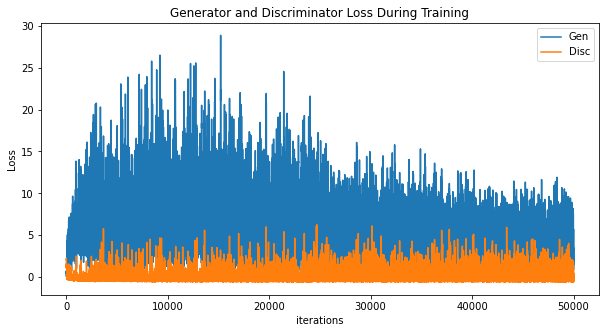

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()